# Notebook Overview

In this notebook we will be reproducing a subset of the methods listed in the paper *Invariant Causal Representation Learning for Out-of-Distribution Generalization* by Lu et al. Mainly, the goal of this notebook, as well as the subset of the paper mentioned, is to show the difference in performance when using different VAE-based models as part of the *iCARL* algorithm introduced in the paper. 

As we described in our final deliverable (which can be found in this repo), the authors of the paper argue from a theoretical mathematical perspective that VAE cannot recreate the true prior distribution and thus cannot be used to predict Y using the *iCARL* meta-algorithm - while i-VAE can in cases where the priors are not dependent, and NF-VAE can even in cases where they are dependent. 

This notebook showcases the ability of the different VAE neural networks to separate the latent variables, and thus identify them. We do so by first creating synthetic data for which we know the true latent variables and their distributions. Then, we run the three mentioned VAE neural nets on them. We evaluate the results using the same methods as in the paper: calculating and comparing the Mean Correlation Coefficient (MCC) as well as plotting the latent variables. 

# Imports

In [12]:

import numpy as np
import pandas as pd

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# packages needed for creating x
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.optim import Adam 

from torch.distributions import Distribution, Normal
import torch.distributions as dist

from typing import *

from torch.utils.data import Dataset, DataLoader

import pdb # for debugging

Here we will also define helper functions we will use later in the notebook.

In [13]:
## Functions for formatting data
def p(x):
    """Converts input array to pandas dataframe"""
    return pd.DataFrame(x)

## Functions for plotting 

def plot_latent_3d(df, m):
    """Plots 3 Latent Variables in 3D"""
    # creating figure
    fig = plt.figure()
    ax = Axes3D(fig)

    # creating the plot
    plot = ax.scatter(df['Z1'], df['Z2'], df['Z3'], c=m)
    # setting title and labels
    ax.set_title("3D plot")
    ax.set_xlabel('Z1-axis')
    ax.set_ylabel('Z2-axis')
    ax.set_zlabel('Z3-axis')

    # displaying the plot
    plt.show()


## Base functions for neural networks 
class Net(nn.Module):
    def __init__(self, num_features, num_hidden, num_output):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_hidden),
            nn.ReLU(),
            nn.Linear(in_features=num_hidden, out_features=num_output),
        )
    def forward(self, Z):
        return self.function(Z)

class Net1(nn.Module):
    def __init__(self, num_features, num_hidden, num_output):
        super(Net1, self).__init__()
        torch.manual_seed(2)
        # hidden layer
        self.W_1 = Parameter(
            init.xavier_normal_(torch.Tensor(num_hidden, num_features))
        )
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # output layer
        self.W_2 = Parameter(
            init.xavier_normal_(torch.Tensor(num_output, num_hidden))
        )
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return x

## Functions for generating data 
class Normal_dist(Distribution):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        with torch.no_grad():
            eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        self.E = torch.nn.functional.one_hot(torch.tensor(E).long())
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))
        
def generate_x_from_z(env, net):
    """ Runs neural network on latent variables to return X"""

    return net(torch.from_numpy(env["Zs"].astype("float32")))

# 1. Data Generation

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn. 

In [14]:
def generate_z_and_y(E, samples, three_z=True):
    """
    Takes in a list of means representing different environments and
    generates latent variables (z's) and y for that environment

    Currently only works for 4 environments and 4 output variables

    Args:
        E (list): A list of four numbers representing four means of four different environments

    Returns:
        _envs (nested dictionary): A nested dictionary containing all environments
        and latent variables for each 
            ex: envs.keys() = [0,1] -> contains data for environment 0 and 1
                envs[0].keys() = ["Y","Zs"] -> Each environment contains a dictionary 
                with a numpy array of Y values and a numpy array for Z values 
                The Z values are organized column wise (ie the first column contains the first latent variable)
    """

    # beta can be stationary or sampled from a normal distribution
    beta_z1 = 1  # np.random.normal(0,1)
    beta_z2 = 1  # np.random.normal(0,1)
    beta_z3 = 1  # np.random.normal(0,1)
    
    E_choice = np.random.choice(np.arange(0,len(E), 1), samples)
    Env = E[E_choice]
    
    Z1 = np.random.normal(Env, 1, size = samples)
    Z2 = np.random.normal(2*Env, 2, size = samples)
    Y = np.random.normal(Z1+Z2, 1, size = samples)
    Z3 = Y + np.random.normal(0, 1, size=samples)
    if three_z==True:
        Z = np.stack([Z1, Z2, Z3], axis = 1)
    else:
        Z = np.stack([Z1, Z2], axis = 1)
        
    return E_choice, Env, Y, Z

In [15]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from (variable $E_{choice}$) and the corresponding 'mean' of that environment ($E$).

In [16]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1) # p function converts to pandas dataframe
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env'] # name columns
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'} #set color scheme
m=df['Env'].map(colors)
df['c']=m # map colors to environments
tdf=df # create copy as the true dataframe 

The below figure shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment. Use matplotlib qt instead of inline if you'd like to be able to rotate the plot etc.

C:\Users\mathi\AppData\Local\Temp/ipykernel_13124/2872198539.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


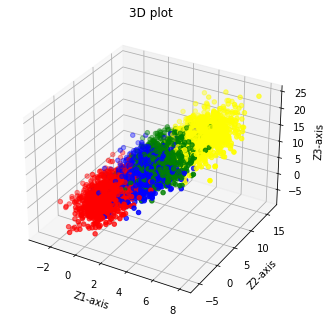

In [17]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units. Since the X-values are dependent on the latent variables, we will generate them twice: once for our test case of having three latent variables and once for our test case of having two latent variables. 

# 2. Testing models in the 3 Z-case #
This section uses synthetic data with 3 latent variables where one is a child of Y. 

First, we will create the X data and set up data to be input in the neural networks. For the data to be used, it must be made into a Pytorch dataset and put into a data loader. We also set the parameters for the neural network to generate data.

In [18]:
# Generate X from Z
net=Net(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [19]:
# Setup loaders for NN input
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [20]:
# Setting parameters for layers of Neural Network
z_dim = 3 # 3 latent variables 
x_y_e = 15 # dimension of y + dim of e + dim of x
x_dim = 10 # 10 output units for X (10 X variables)
ye_dim = 5 # dimension of y + dimension of e
y_dim = 1 # Y variable is one dimensional

## 2.2 VAE ##

### 2.2.1 Setting up VAE code ###
In this section we will be defining and training the VAE which we will be testing the performance of. 

Skip subsection at your own leisure.

In [21]:
class VAE(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, beta=1):
        super().__init__()
        # prior_params
        self.prior_mean = torch.zeros(1).to('cpu')
        self.logl = torch.zeros(1).to('cpu')
        
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
        # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.func_prior = nn.Sequential(
                nn.Linear(in_features=input_size_pr, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_pr*2)
            )
        
        self.normal_dist = Normal_dist() # call function to define normal distribution, like in Week 7
        
    def reparametrize(self, mu, logvar):
        """Reparameterization trick from Week 7"""
        std = torch.exp(0.5*logvar)
        eps = self.normal_dist.sample(mu, std)
        return mu + eps * std
    
    def prior_params(self):
        """Returns the prior parameters"""
        return self.prior_mean, self.logl.exp()
    
    def forward(self, x, y, e, beta=1):
        """Forward Pass of iVAE"""
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get prior params
        prior_params = self.prior_params()
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        
        #zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.reparametrize(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        return zu, zsigma, de_u, z, prior_params

    
    def elbo(self, x, y, e, beta=1):
        """ELBO function for NN training, 
        now with the prior coming from a conditioned distribution"""
        zu, zsigma, de_u, z, prior_params = self.forward(x, y, e)
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xy = self.normal_dist.log_pdf(z, zu, zsigma.exp())
        log_pz_ye = self.normal_dist.log_pdf(z, *prior_params)

        # And compute kl and elbo
        kl = -log_qz_xy + log_pz_ye

        elbo = log_px_z + beta*kl
        #pdb.set_trace()

        return elbo.mean()    

#### Training

Epoch 20 of 1000
Train loss: tensor(104.5168)
Epoch 40 of 1000
Train loss: tensor(45.6944)
Epoch 60 of 1000
Train loss: tensor(27.0285)
Epoch 80 of 1000
Train loss: tensor(18.1856)
Epoch 100 of 1000
Train loss: tensor(9.8389)
Epoch 120 of 1000
Train loss: tensor(5.5363)
Epoch 140 of 1000
Train loss: tensor(3.0026)
Epoch 160 of 1000
Train loss: tensor(1.5369)
Epoch 180 of 1000
Train loss: tensor(0.4114)
Epoch 200 of 1000
Train loss: tensor(-0.3696)
Epoch 220 of 1000
Train loss: tensor(-0.9491)
Epoch 240 of 1000
Train loss: tensor(-1.2365)
Epoch 260 of 1000
Train loss: tensor(-1.7816)
Epoch 280 of 1000
Train loss: tensor(-2.1422)
Epoch 300 of 1000
Train loss: tensor(-2.4802)
Epoch 320 of 1000
Train loss: tensor(-2.8650)
Epoch 340 of 1000
Train loss: tensor(-3.3066)
Epoch 360 of 1000
Train loss: tensor(-3.8608)
Epoch 380 of 1000
Train loss: tensor(-4.3187)
Epoch 400 of 1000
Train loss: tensor(-4.6331)
Epoch 420 of 1000
Train loss: tensor(-4.7808)
Epoch 440 of 1000
Train loss: tensor(-4.93

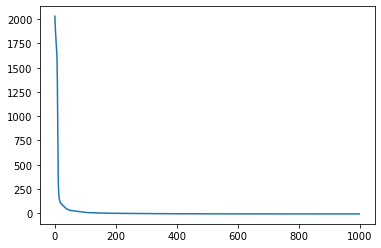

In [22]:
# Define parameters
z_dim=3
x_y_e=15
x_dim=10
net_vae=VAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, z_dim, beta=1)

# Define optimizer
optimizer = Adam(net_vae.parameters(), lr=1e-3)

# Set # of epochs, and variables to store outputs in
epochs = 1000
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

# Train
for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_vae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
plt.plot(train_loss)
plt.show()

### 2.2.2 VAE results ###

Here, we test the VAE, and extract the latent variables. 

In [23]:
# Set up loader and output variables
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0

# Test
for x,y,e in loader:
    zu, zsigma, de_u, z, prior_params = net_vae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach() # put the latent variables for this load in the output dataframe
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int) # same for environment
    i+=1


We can take the aggregated output from the testing loop, and reformat it in a dataframe, where the different variables as well as the corresponding environments they came from are columns. We can also assign a color to each environment. 

In [24]:
# Merge results and format
df_vae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1) 
df_vae.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_vae=df_vae['Env'].map(colors)
df_vae['c']=m

Now, we can plot the estimated latent variables: 

In [25]:
## Uncomment the qt line if you'd like to be able to rotate the plot
#%matplotlib qt
#plot_latent_3d(df_vae, m_vae)

In order to calculate the MCC (the testing metric stated earlier), we first need to extract the true and predicted latent variable values. To do this, we will put the two in separate dataframes. Because we are comparing the results for the test set, we will extract the true variables from indices 2000 to 3920. We do this because the indices 2000 to 4000 are for test set but only full batches are predicted for, and the last 80 values are the remainder which did not fit in a batch. 

In [26]:
p_df_vae=df_vae[['Z1', 'Z2', 'Z3']] # extract prediction of latent vars
p_df_vae.columns = ['pZ1', 'pZ2', 'pZ3']
c_df_vae=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:] # get true latent variables

#### Calculating MCC 

Like in the paper, we will calculate the Mean Correlation Coefficient (MCC) as a test statistic. In terms of their implementation, Lu et al simply states " [the MCC] can be obtained by calculating the correlation coefficient between all pairs of true and recovered latent factors and then solving a linear sum assignment problem by assigning each recovered latent factor to the true latent factor with which it best correlates". Based on this, we created the function below. 

In [27]:
def MCC(true_z, predicted_z):
    """Caluclates the Correlation Coefficient between all pairs of true 
    and recovered latent variables for one environment 

    Uses Pearsons Corr Coef

    Args:
        true_z (numpy array): 2D dimensional numpy array, where columns represent variables
        predicted_z (numpy array): as above
    """
    # Get number of variables
    num_true = len(true_z[0])
    num_predicted = len(predicted_z[0])
    # Calculate correlation coefficient between every pair 
    corr_matrix = np.abs(np.corrcoef(true_z, predicted_z, rowvar=False))
    # Reduce matrix to only contain pairs where one true is compared to 
    # one predicted
    reduced_matrix = corr_matrix[
        0:num_true, num_true : len(corr_matrix[0]) + 1
    ]  # where rows are true and columns are predicted

    # Solve linear sum assignment
    row_ind, col_ind = linear_sum_assignment(reduced_matrix, maximize=True)

    # Extract entries which solve linear sum assignment
    mcc = [reduced_matrix[row_ind[i], col_ind[i]] for i in range(len(row_ind))]

    # Take mean of solved linear sum assignment
    mcc = np.sum(mcc) / (num_predicted)
    
    return mcc

Now we implement our MCC function to this test for VAE, as well as the rest of our tests.

In [28]:
# Calculate MCC
mcc_vae=MCC(c_df_vae.values, p_df_vae.values) 
MCC(c_df_vae.values, p_df_vae.values)

0.44430080135746425

## 2.2 iVAE ##

### 2.2.1 Setting up the iVAE code ###
The following block defines the iVAE, which will be testing the performance of. iVAE varies from VAE in that we are using Y and E as conditions to the prior probability, as described in Appendix N.1.5 of the paper by Lu et al. 

 Collapse this block if you'd just like to move on and see the results.

In [29]:

class iVAE(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
        # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # MLP for Prior Distribution
        self.func_prior = nn.Sequential(
                nn.Linear(in_features=input_size_pr, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_pr*2)
            )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye) # run encoder with formatted input
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp() # take exponent of returned log sigma parameter
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        # Get prior params
        ye = torch.cat((y, e), 1) #format input to prior MLP
        prior_u, prior_sigma = self.func_prior(ye).chunk(2, axis = -1)
        prior_sigma = prior_sigma.exp()
        
        return zu, zsigma, de_u, prior_u, prior_sigma, z
    
    def elbo(self, x, y, e, beta=1):
        zu, zsigma, de_u, prior_u, prior_sigma, z = self.forward(x, y, e)
        
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu') # 0.01, variance for prior
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        log_pz_ye = self.normal_dist.log_pdf(z, prior_u, prior_sigma)

        # And compute kl and elbo
        kl = -log_qz_xye + log_pz_ye

        elbo = log_px_z + beta*kl

        return elbo.mean()

    
    

### 2.1.2 iVAE results #

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


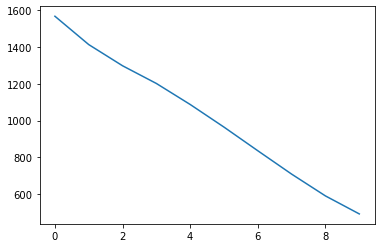

In [30]:
net_ivae=iVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, 3, beta=1)
x,y,e = next(iter(train_loader))
#elbo = net_ivae.elbo(x.float(),y.float(),e.float())

optimizer = Adam(net_ivae.parameters(), lr=1e-3)

epochs = 10
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    #if epoch < 20:
    #    beta = 10
    #else:
    #    beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_ivae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
plt.plot(train_loss)
plt.show()


In [31]:
# Set up loader and output vars
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0

# Testing
for x,y,e in loader:
    _, _, _, _, _, z = net_ivae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
# Formatting results 
df_ivae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_ivae.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_ivae=df_ivae['Env'].map(colors)
df_ivae['c']=m


In [32]:
## Uncomment the qt line if you'd like to be able to rotate the plot
#%matplotlib qt
#plot_latent_3d(df_ivae, m_ivae)

In [33]:
# Set up dataframes for MCC
pdf_ivae=df_ivae[['Z1', 'Z2', 'Z3']]
pdf_ivae.columns = ['pZ1', 'pZ2', 'pZ3']
cdf_ivae=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]

In [34]:
# Calculate MCC
mcc_ivae=MCC(cdf_ivae.values, pdf_ivae.values)
MCC(cdf_ivae.values, pdf_ivae.values)

0.6901827055668309

## 2.3 NF-VAE ##

### 2.3.1 NF-VAE ###
In this section we implement, train and test the NF-VAE algorithm. We implemented the prior as described in Appendix N.1.5 of the paper by Lu et al. 

Collapse subsection at your own leisure.

In [35]:
class NFVAE(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, y_dim, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
                # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.TNN = nn.Sequential(
            nn.Linear(in_features=input_size_de, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaNN = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaf = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=input_size_de*2*2)
        )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        
        return zu, zsigma, de_u, z
    
    def elbo(self, x, y, e, beta=1):
        # Get encoder and decoder params
        zu, zsigma, de_u, z = self.forward(x, y, e)
        
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        
        # Get prior params
        ye = torch.cat((y.detach(),e.detach()),1)
        
        TNN_params, _ = self.TNN(z_temp).chunk(2, axis = -1)
        lambdaNN_params, _ = self.lambdaNN(ye).chunk(2, axis = -1)
        lambdaf_params, _ = self.lambdaf(ye).chunk(2, axis = -1)
        
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z_temp, z_temp.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)
        pz_ye = nn_ + f_
        
        dpz_ye = torch.autograd.grad(pz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)

        elbo = log_px_z - log_qz_xye + pz_ye.detach()

        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

    
    

In [36]:
# Set NN parameters 
z_dim = 3
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1

# Run NN with parameters 
net_icarl=NFVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

# Set up Optimizer
optimizer = Adam(net_icarl.parameters(), lr=1e-3)

# Training
epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    # if epoch < 20:
    #     beta = 10
    # else:
    #     beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net_icarl.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 20 of 200
Train loss: tensor(37.9796)
Epoch 40 of 200
Train loss: tensor(-13.1073)
Epoch 60 of 200
Train loss: tensor(-76.2407)
Epoch 80 of 200
Train loss: tensor(-103.7430)
Epoch 100 of 200
Train loss: tensor(-94.9736)
Epoch 120 of 200
Train loss: tensor(-96.1511)
Epoch 140 of 200
Train loss: tensor(-86.1929)
Epoch 160 of 200
Train loss: tensor(-77.6532)
Epoch 180 of 200
Train loss: tensor(-70.9428)
Epoch 200 of 200
Train loss: tensor(-65.9483)


### 2.3.2 NF-VAE results ###

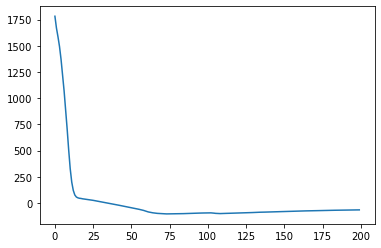

In [37]:
%matplotlib inline
plt.plot(train_loss)
plt.show()

# Set up loader and output variables
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0

# Testing 
for x,y,e in loader:
    _, _, _, z = net_icarl.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

# Format Results
df_nfvae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_nfvae.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_nfvae=df_nfvae['Env'].map(colors)
df_nfvae['c']=m

# Set up dataframes for MCC
pdf_nfvae=df_nfvae[['Z1', 'Z2', 'Z3']]
pdf_nfvae.columns = ['pZ1', 'pZ2', 'pZ3']
cdf_nfvae=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]

In [38]:
# Calculate MCC
mcc_icarl = MCC(cdf_nfvae.values, pdf_nfvae.values)
MCC(cdf_nfvae.values, pdf_nfvae.values)

0.8054137110596674

## 2.4 Summary of results of the three methods ##


### 2.4.1 Posterior plots ###

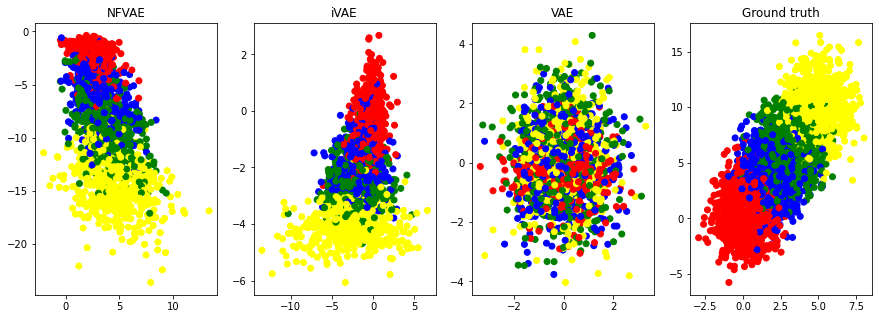

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.scatter(df_nfvae['Z1'], df_nfvae['Z2'], c=m_nfvae)
ax1.set_title('NFVAE')
ax2.scatter(df_ivae['Z1'], df_ivae['Z2'], c=m_ivae)
ax2.set_title('iVAE')
ax3.scatter(df_vae['Z1'], df_vae['Z2'], c=m_vae)
ax3.set_title('VAE')
ax4.scatter(df['Z1'], df['Z2'], c=m)
ax4.set_title('Ground truth')
plt.show()

### 2.4.2 MCC ###

<BarContainer object of 3 artists>

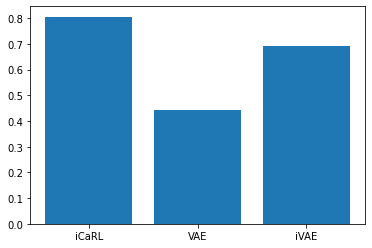

In [40]:
mccs=np.array([mcc_icarl, mcc_vae, mcc_ivae])
plt.bar(['iCaRL', 'VAE', 'iVAE'], mccs)

### 2.4.3 3D plots ###

C:\Users\mathi\AppData\Local\Temp/ipykernel_13124/2872198539.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


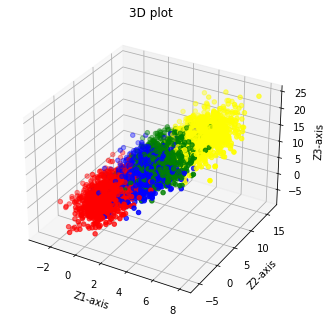

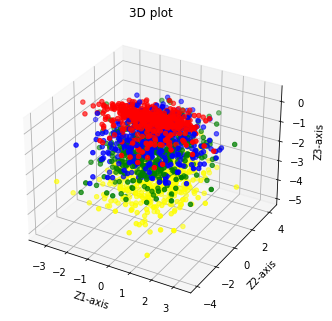

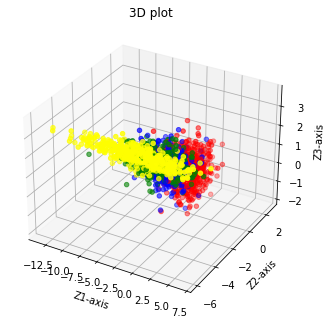

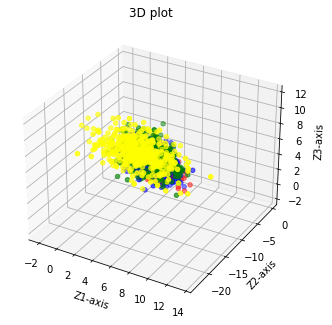

In [41]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)
plot_latent_3d(df_vae, m_vae)
plot_latent_3d(df_ivae, m_ivae)
plot_latent_3d(df_nfvae, m_nfvae)

# 3. Case with just 2 latent variables #
In this section the third latent variable (child of y) has been omitted and the autoencoders are once more used to regenerate the latent variables.

In [42]:
# Data Generation
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

In [43]:
# Formatting data
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
#df.round(2)

We can plot the generated data to observe how the classes overlap.

Text(0, 0.5, 'Z2-axis')

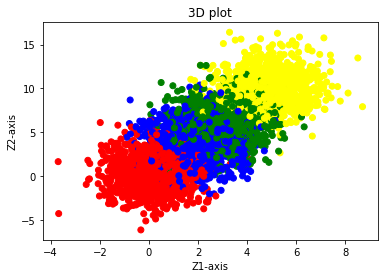

In [44]:
#%matplotlib qt
#plot_latent_3d(df, m)

fig = plt.figure()
# creating the plot
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("3D plot")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')

Next, we can regenerate the X data, now for two latent variables. We can also set up the datasets to be input to the neural networks.

In [45]:
# Generate X data
net=Net1(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

# Format data for neural networks
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

Now, we can set the hyperparameters for the NN. 

In [46]:
z_dim = 2
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1

## 3.1 Running the models ##
In each subsection, we will use the VAE classes defined in Section 2 to train and test data created with two latent variables. 

### 3.1.1 VAE ###

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 20 of 100
Train loss: tensor(46.9635)
Epoch 40 of 100
Train loss: tensor(4.5474)
Epoch 60 of 100
Train loss: tensor(1.3635)
Epoch 80 of 100
Train loss: tensor(0.1338)
Epoch 100 of 100
Train loss: tensor(-1.7061)


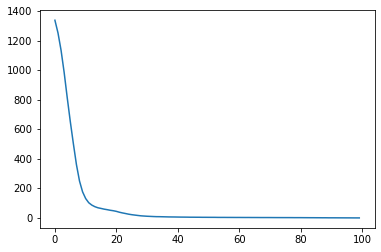

In [47]:
z_dim=2
x_y_e=15
x_dim=10
net_vae=VAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, z_dim, beta=1)

from torch.optim import Adam
optimizer = Adam(net_vae.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)
mccs_vae = []

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_vae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
    # SET UP TEST SET EVALUATION
    # get z
    loader = test_loader
    latent_variables = torch.zeros((len(train_loader)*128, 2))
    envs_samp = np.zeros((len(train_loader)*128, 4))
    i = 0
    for x,y,e in loader:
        #_, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
        zu, zsigma, de_u, z, prior_params = net_vae.forward(x.float(), y.float(), e.float(), beta=1)
        latent_variables[i*128:i*128+128,:] = z.detach()
        envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
        i+=1
    
    # Create dataframes
    df_vae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
    df_vae.columns = ['Z1', 'Z2', 'Env']
    colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
    m_vae=df_vae['Env'].map(colors)
    df_vae['c']=m
    #df.round(2)

    pdf_vae=df_vae[['Z1', 'Z2']]
    pdf_vae.columns = ['pZ1', 'pZ2']
    cdf_vae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
    #cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
    cdf_vae['pZ1']=pdf_vae['pZ1'].values
    cdf_vae['pZ2']=pdf_vae['pZ2'].values

    # Calculate MCC
    mcc_vae=MCC(cdf_vae.iloc[:,:2].values, pdf_vae.values)
    mccs_vae.append(mcc_vae)
    
plt.plot(train_loss)
plt.show()

In [48]:
# Get z for final epoch only
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    zu, zsigma, de_u, z, prior_params = net_vae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_vae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_vae.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_vae=df_vae['Env'].map(colors)
df_vae['c']=m

In [49]:
p_df_vae=df_vae[['Z1', 'Z2']]
p_df_vae.columns = ['pZ1', 'pZ2']
c_df_vae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]

In [50]:
# Calculate MCC
mcc_vae=MCC(c_df_vae.values, p_df_vae.values)
MCC(c_df_vae.values, p_df_vae.values)

0.863380697809328

### 3.1.2 iVAE ###


C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 20 of 100
Train loss: tensor(43.8497)
Epoch 40 of 100
Train loss: tensor(5.2520)
Epoch 60 of 100
Train loss: tensor(0.6341)
Epoch 80 of 100
Train loss: tensor(-1.2471)
Epoch 100 of 100
Train loss: tensor(-2.3078)


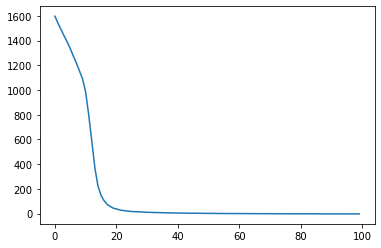

In [51]:
net_ivae=iVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, z_dim, beta=1)
x,y,e = next(iter(train_loader))

from torch.optim import Adam
optimizer = Adam(net_ivae.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)
mccs_ivae = []
pz1_z1_list = []
pz1_z2_list = []
pz2_z1_list = []
pz2_z2_list = []


for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_ivae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
    # SET UP TEST SET EVALUATION
    # get z
    loader = test_loader
    latent_variables = torch.zeros((len(train_loader)*128, 2))
    envs_samp = np.zeros((len(train_loader)*128, 4))
    i = 0
    for x,y,e in loader:
        _, _, _, _, _, z = net_ivae.forward(x.float(), y.float(), e.float(), beta=1)
        latent_variables[i*128:i*128+128,:] = z.detach()
        envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
        i+=1
    
    # Create dataframes
    df_ivae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
    df_ivae.columns = ['Z1', 'Z2', 'Env']
    colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
    m_ivae=df_ivae['Env'].map(colors)
    df_ivae['c']=m

    # Merge dataframes together (pdf = predicted_df, tdf = true_df, cdf = correlation_df)
    pdf_ivae=df_ivae[['Z1', 'Z2']]
    pdf_ivae.columns = ['pZ1', 'pZ2']
    cdf_ivae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
    cdf_ivae['pZ1']=pdf_ivae['pZ1'].values
    cdf_ivae['pZ2']=pdf_ivae['pZ2'].values
    pz1_z1=cdf_ivae.corr().iloc[2:, :2].iloc[0,0]
    pz1_z2=cdf_ivae.corr().iloc[2:, :2].iloc[0,1]
    pz2_z1=cdf_ivae.corr().iloc[2:, :2].iloc[1,0]
    pz2_z2=cdf_ivae.corr().iloc[2:, :2].iloc[1,1]

    # Calculate MCC
    mcc_ivae=MCC(cdf_ivae.iloc[:,:2].values, pdf_ivae.values)
    mccs_ivae.append(mcc_ivae)
    pz1_z1_list.append(pz1_z1)
    pz1_z2_list.append(pz1_z2)
    pz2_z1_list.append(pz2_z1)
    pz2_z2_list.append(pz2_z2)
    
plt.plot(train_loss)
plt.show()


In [52]:
# Get z for final epoch only
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net_ivae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_ivae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_ivae.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_ivae=df_ivae['Env'].map(colors)
df_ivae['c']=m

pdf_ivae=df_ivae[['Z1', 'Z2']]
pdf_ivae.columns = ['pZ1', 'pZ2']
cdf_ivae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]

In [53]:
# Calculate MCC
mcc_ivae=MCC(cdf_ivae.values, pdf_ivae.values)
MCC(cdf_ivae.values, pdf_ivae.values)

0.927812587723871

### 3.1.3 NF-VAE ###

For the NF-VAE we also test the reconstruction loss. Due to time constraints we just use the means from the decoder as surrogates for the X-values (i.e. we assume variance is zero).

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 20 of 100
Train loss: tensor(-4.9634)
Epoch 40 of 100
Train loss: tensor(-72.6662)
Epoch 60 of 100
Train loss: tensor(-80.3669)
Epoch 80 of 100
Train loss: tensor(-73.9906)
Epoch 100 of 100
Train loss: tensor(-69.9896)


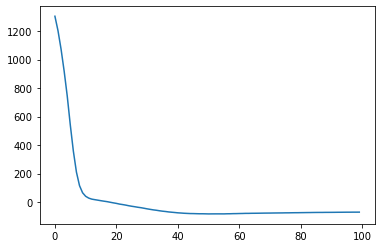

In [54]:
z_dim = 2
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1
net_icarl=NFVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

from torch.optim import Adam
optimizer = Adam(net_icarl.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)
mccs_icarl = []
pz1_z1_list = []
pz1_z2_list = []
pz2_z1_list = []
pz2_z2_list = []
x_mse = []

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net_icarl.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
    # TEST SET PERFORMANCE
    # get z and de_u
    loader = test_loader
    latent_variables = torch.zeros((len(train_loader)*128, 2))
    envs_samp = np.zeros((len(train_loader)*128, 4))
    x_samp = torch.zeros((len(train_loader)*128, 10))
    i = 0
    for x,y,e in loader:
        _, _, de_u, z = net_icarl.forward(x.float(), y.float(), e.float(), beta=1)
        latent_variables[i*128:i*128+128,:] = z.detach()
        envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
        x_samp[i*128:i*128+128,:] = de_u.detach() # Get decoder means and use them as approximation of x
        i+=1
    
    # Create dataframes (pdf = predicted_df, tdf = true_df, cdf = correlation_df)
    df_icarl=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
    df_icarl.columns = ['Z1', 'Z2', 'Env']
    colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
    m_icarl=df_icarl['Env'].map(colors)
    df_icarl['c']=m

    pdf_icarl=df_icarl[['Z1', 'Z2']]
    pdf_icarl.columns = ['pZ1', 'pZ2']
    cdf_icarl=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
    cdf_icarl['pZ1']=pdf_icarl['pZ1'].values
    cdf_icarl['pZ2']=pdf_icarl['pZ2'].values
    #df.round(2)
    pz1_z1=cdf_icarl.corr().iloc[2:, :2].iloc[0,0]
    pz1_z2=cdf_icarl.corr().iloc[2:, :2].iloc[0,1]
    pz2_z1=cdf_icarl.corr().iloc[2:, :2].iloc[1,0]
    pz2_z2=cdf_icarl.corr().iloc[2:, :2].iloc[1,1]
    mcc_icarl = MCC(cdf_icarl.iloc[:,:2].values, pdf_icarl.values)
    mccs_icarl.append(mcc_icarl)
    
    pz1_z1_list.append(pz1_z1)
    pz1_z2_list.append(pz1_z2)
    pz2_z1_list.append(pz2_z1)
    pz2_z2_list.append(pz2_z2)
    
    # Calculate MSE for reconstructed X
    x_mse.append(np.mean(((X[2000:3920]-x_samp.numpy())**2)))
    
    
plt.plot(train_loss)
plt.show()

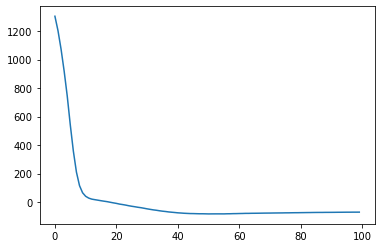

In [55]:
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, z = net_icarl.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_nfvae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_nfvae.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_nfvae=df_nfvae['Env'].map(colors)
df_nfvae['c']=m

pdf_nfvae=df_nfvae[['Z1', 'Z2']]
pdf_nfvae.columns = ['pZ1', 'pZ2']
cdf_nfvae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]

In [56]:
# Calculate MCC
mcc_icarl = MCC(cdf_nfvae.iloc[:,:2].values, pdf_nfvae.values)
MCC(cdf_nfvae.iloc[:,:2].values, pdf_nfvae.values)

0.8546281666305378

Plot the predicted_Z1-true_Z1 and predicted_Z2-true_Z2 correlations as well as the MSE of the reconstructed X as a function of epochs.

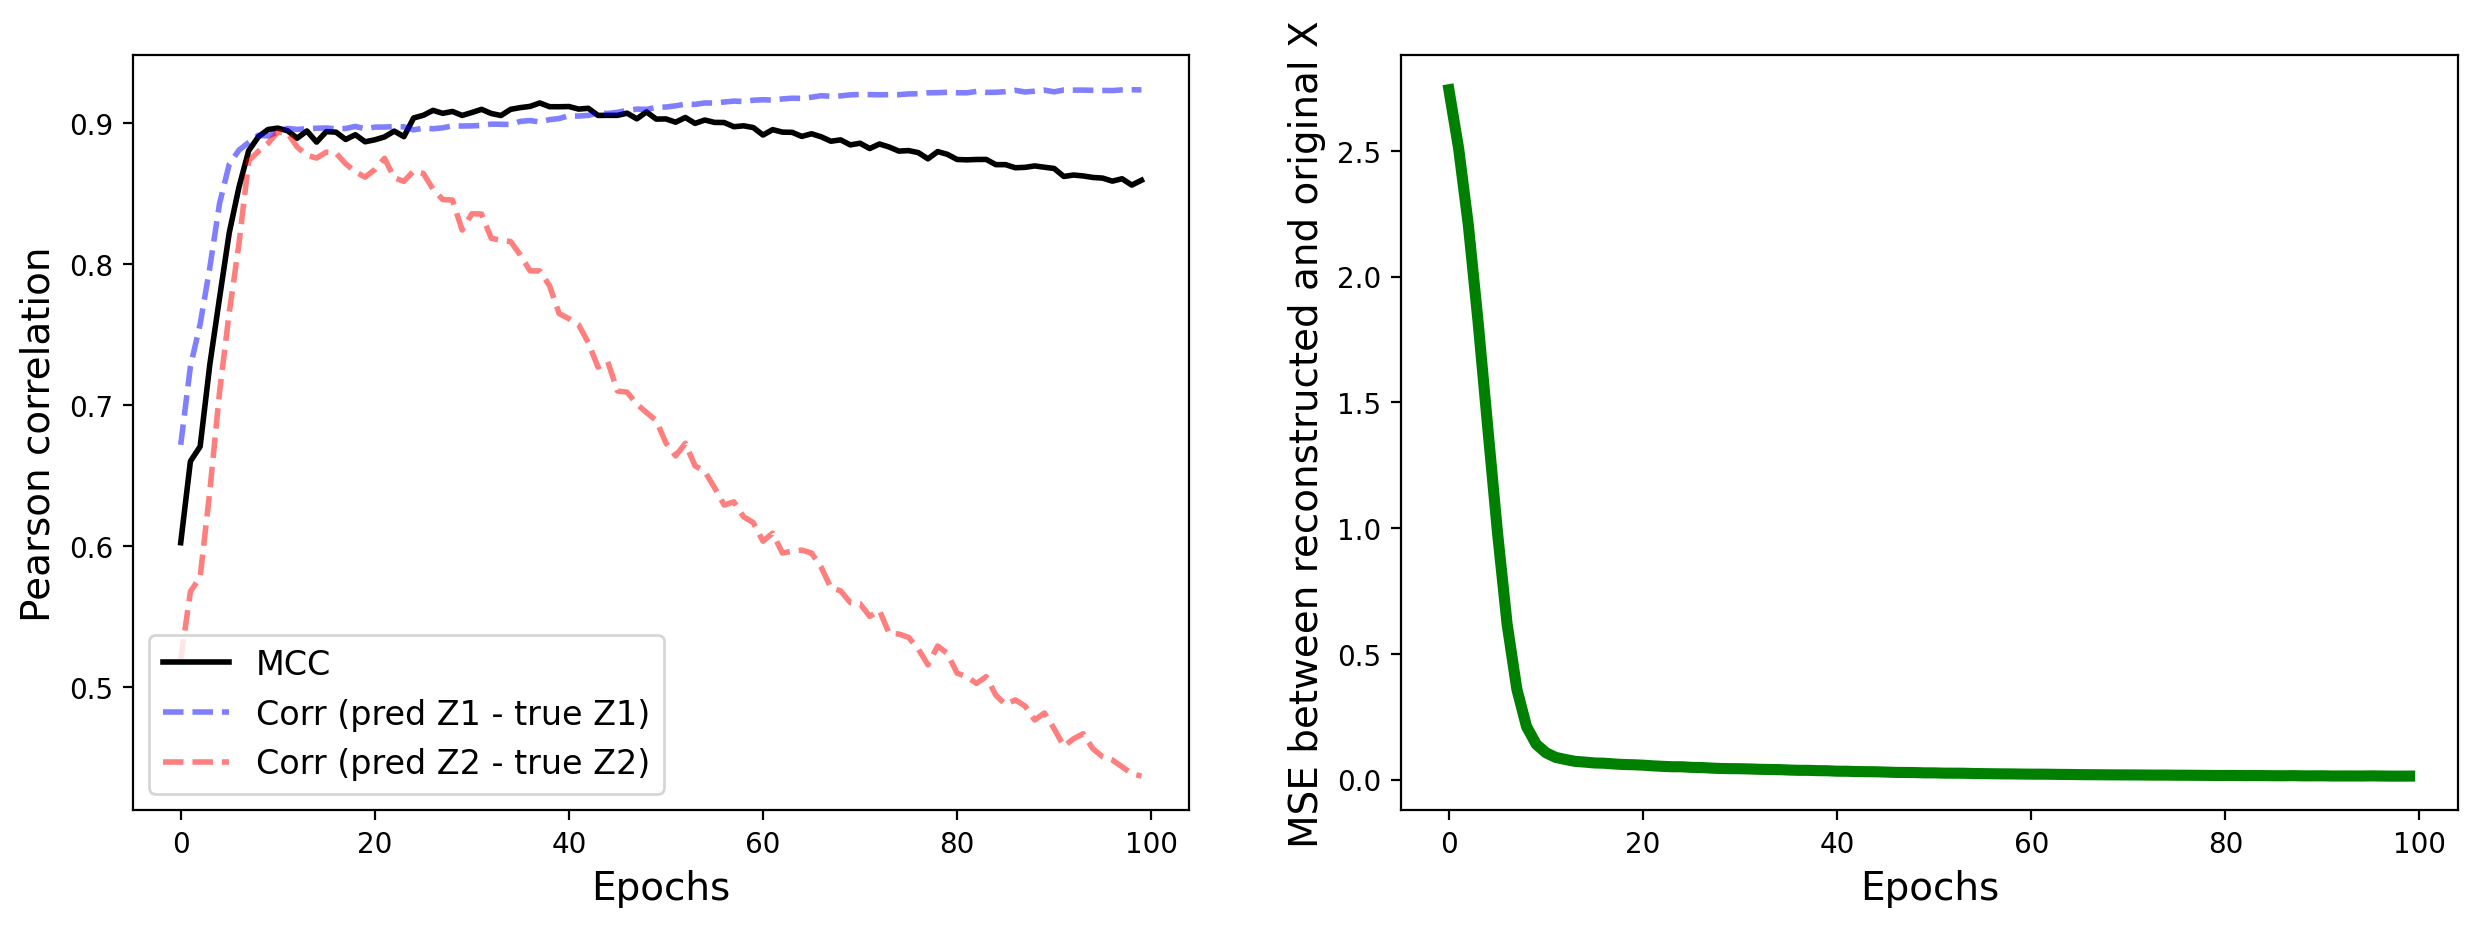

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1.plot(mccs_icarl, color='black', linewidth=2)
ax1.plot(np.abs(pz1_z1_list), color='blue', alpha=0.5, linestyle='--', linewidth=2)
#plt.plot(np.abs(pz1_z2_list), color='green', alpha=0.5, linestyle='--')
#plt.plot(np.abs(pz2_z1_list), color='orange', alpha=0.5, linestyle='--')
ax1.plot(np.abs(pz2_z2_list), color='red', alpha=0.5, linestyle='--', linewidth=2)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Pearson correlation', fontsize=14)
ax1.legend(['MCC','Corr (pred Z1 - true Z1)', 'Corr (pred Z2 - true Z2)'], fontsize=12)
ax2.plot(x_mse, color='green', linewidth=4)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('MSE between reconstructed and original X', fontsize=14)
plt.savefig('ReasonForDeterioratingPerformance.jpg')
plt.show()
#plt.ylim(0.9,0.93)

## 3.4 Summary of results of the three methods ##

### 3.4.1 Posterior plots ###

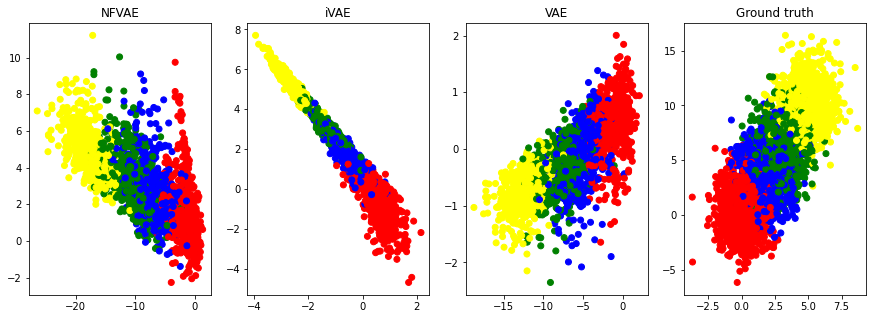

In [58]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.scatter(df_nfvae['Z1'], df_nfvae['Z2'], c=m_nfvae)
ax1.set_title('NFVAE')
ax2.scatter(df_ivae['Z1'], df_ivae['Z2'], c=m_ivae)
ax2.set_title('iVAE')
ax3.scatter(df_vae['Z1'], df_vae['Z2'], c=m_vae)
ax3.set_title('VAE')
ax4.scatter(df['Z1'], df['Z2'], c=m)
ax4.set_title('Ground truth')
plt.show()

### 3.4.2 MCC ###

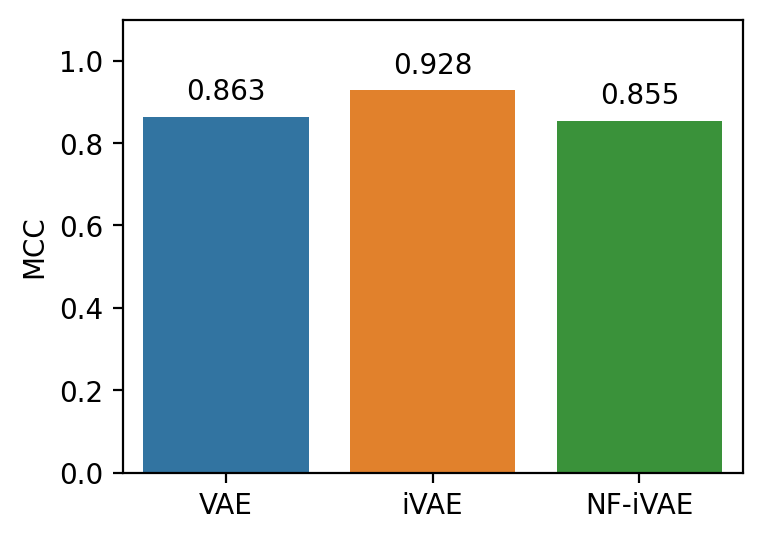

In [62]:
mccs=np.array([mcc_vae, mcc_ivae, mcc_icarl])
#plt.bar(['VAE', 'iVAE', 'iCaRL'], mccs, color=['blue', 'orange', 'green'], label=['1', '1', '1'])
dfmccs=p(mccs)
dfmccs['x']=['VAE', 'iVAE', 'NF-iVAE']
plt.figure(figsize=(4, 3), dpi=200)
splot=sns.barplot(x="x",y=0,data=dfmccs)
for i in splot.patches:
    splot.annotate(format(i.get_height(), '.3f'), 
                   (i.get_x() + i.get_width() / 2., i.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0, 1.1)
plt.xlabel('')
plt.ylabel('MCC')
plt.savefig('MCC.jpg')

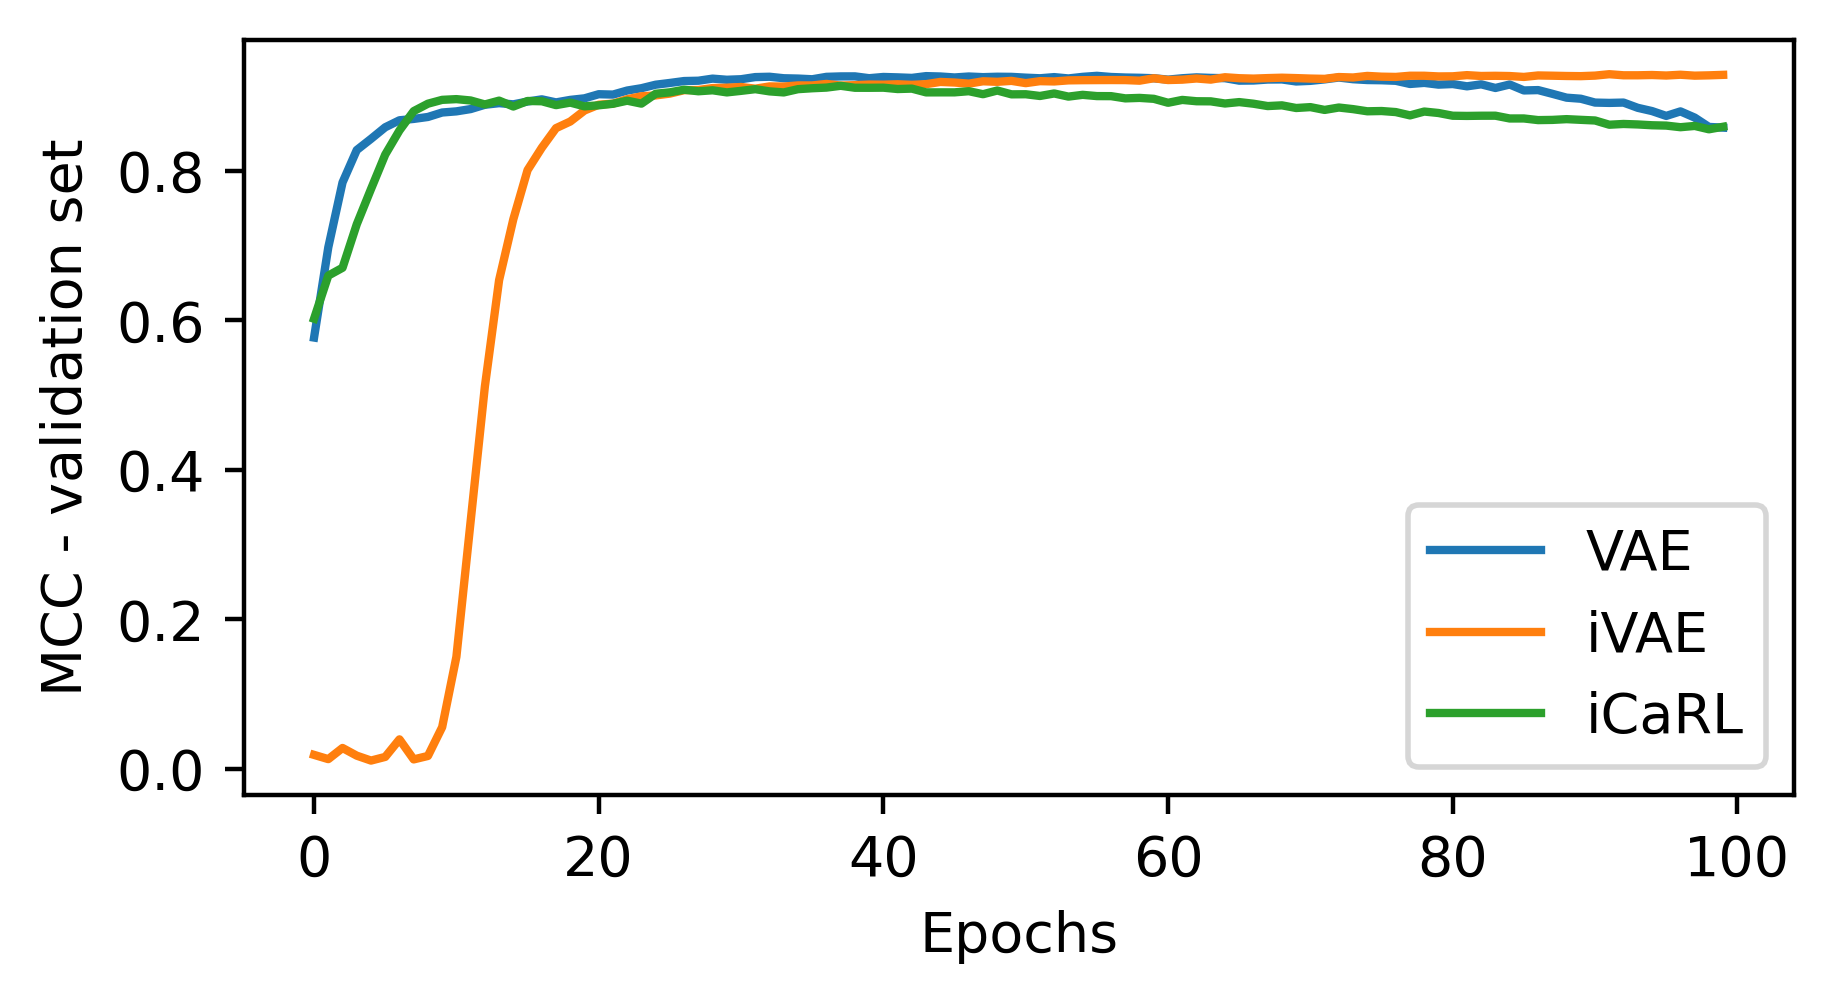

In [63]:
plt.figure(figsize=(5,2.5), dpi=400)
plt.plot(mccs_vae)
plt.plot(mccs_ivae)
plt.plot(mccs_icarl)
plt.legend(['VAE', 'iVAE', 'iCaRL'])
plt.xlabel('Epochs')
plt.ylabel('MCC - validation set')
plt.savefig('Epoch_Curve.jpg')
plt.show()

## 4.0 Validating with PC algorithm 

Originally, we attempted to use the PC algorithm to validate that our latent variables were being found correctly. The success of this approach proved to be unstable. We believe this is due to the same shortcomings of the dataset that we described in our Synthetic Data report section, highlighting the problems we encountered with it and MCC. However, we are including our code for the PC algorithm below, to provide a source for the figures we added to our poster. 

First, we import the Causal Discovery Toolbox, from which we use the PC algorithm function. To install the package and the necessary add-ons for the PC algorithm, one can use the [installation instructions on the package github](https://github.com/FenTechSolutions/CausalDiscoveryToolbox).

In [60]:
# PC alg imports 
import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # this path should point to your own R implementation, if needed
from cdt.causality.graph import PC
import networkx as nx

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


We can extract the latent variables from the testing step. Below, we take the model created for iVAE, and extract the latent variables from its forward run. 

In [61]:
loader = test_loader
pc_vars = torch.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net_ivae.forward(x.float(), y.float(), e.float(), beta=1)
    pc_vars[i*128:i*128+128,0:3] = z.detach() #predicted z
    pc_vars[i*128:i*128+128,3:4] = y.detach() # y
    i+=1

RuntimeError: The expanded size of the tensor (3) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [128, 3].  Tensor sizes: [128, 2]

We convert the data to Pandas dataframe, the required input datatype for the PC algorithm. 

In [ ]:
pc_vars.shape
pc_df = pd.DataFrame(pc_vars.numpy(), columns = ['Z1', 'Z2', 'Z3', 'Y'])

Next we run the PC algorithm. 

In [ ]:
pc_test = PC(
    CItest="gaussian", alpha=0.05, verbose=False
).create_graph_from_data(pc_df)

Now, we can use networkx to display the result. 

In [ ]:
nx.draw(pc_test, with_labels=True, font_weight="bold")
plt.show()